In [1]:
# Make imports 
import numpy as np
import pandas as pd
import seaborn as sns
import spacy
nlp = spacy.load("en_core_web_lg")

In [2]:
# Load in the dataset(s) to be used 
df = pd.read_csv('./hacker_news_sample.csv')

# Identify objectives: find the saltiest commentators of the most discursive
df.head()
#df.text[0]

# Check for hackers gone fishing -> only care about the majors
df.by.isna().sum()

# Identify the most frequent contributers
# df.by.value_counts(normalize=True)[:20] # tptacek takes the cake
# sum(df.by.value_counts()) # 3541759 total commentators 
# sum(df.by.value_counts(normalize=True)[:20])) # top-20 account for 2.37% (84067) of all comments

# List the top-20
top20 = pd.DataFrame(df.by.value_counts()[:20])
top20 = top20.reset_index()
top20 = top20.rename(columns = {'index': 'by', 'by':'total_comments'})
top20_list = top20.by

In [3]:
# Take those texts 
df_top = df[df['by'].isin(top20_list)]

# Check output
sum(df_top.by.value_counts())

84067

In [4]:
# Pre-processing of text

# Imports

import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.parsing.preprocessing import STOPWORDS
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models.ldamulticore import LdaMulticore

# Spacy for lemmatization
import spacy

# Plotting tools
!pip install pyLDavis
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline


In [5]:
def tokenize(x):
    text = x.lower()
    text = re.sub(r'[^a-zA-Z ^0-9]', '', str(text))
    return text.split()

In [6]:
# Applying NLP Sentiment Analysis - TextBlob here

# Imports
!pip install TextBlob
from textblob import TextBlob

import numpy as np
import nltk
import nltk.data

from nltk import tokenize
from nltk.tokenize import sent_tokenize

sent_detector = nltk.data.load('tokenizers/punkt/english.pickle')

/Users/Person/anaconda3/envs/NLP/lib/python3.7/site-packages/nltk/decorators.py:68: DeprecationWarning: `formatargspec` is deprecated since Python 3.5. Use `signature` and the `Signature` object directly
  regargs, varargs, varkwargs, defaults, formatvalue=lambda value: ""


In [7]:
# Depending on format of doc/text entries, may want to consider
#  formatting before applying TextBlob. If not, this cell may be 
#  applied in place of the next cell. 

# # compute sentiment scores (polarity) and labels
# sentiment_scores_tb = [round(TextBlob(article).sentiment.polarity, 3) for article in su_transcripts2['text']]
# sentiment_category_tb = ['positive' if score > 0 
#                              else 'negative' if score < 0 
#                                  else 'neutral' 
#                                      for score in sentiment_scores_tb]

# # sentiment statistics per category
# df = pd.DataFrame([list(su_transcripts['year']), sentiment_scores_tb, sentiment_category_tb]).T
# df.columns = ['year', 'sentiment_score', 'sentiment_category']
# df['sentiment_score'] = df.sentiment_score.astype('float')
# df.groupby(by=['year']).describe()

In [8]:
# Reindex
comments = pd.DataFrame({'text': df_top.text, 'tag': df_top.by}).reset_index()
comments = comments.drop('index', axis = 1)
comments.head()

,text,tag
0,&gt;<i>which leads me to say why are you using...,coldtea
1,&#62; If the application becomes successful yo...,eru
2,Borland WebBuilder.,jacquesm
3,Thanks I will look into Pamela Smith&#x27;s wo...,anigbrowl
4,The article mentions infants who are at greate...,DanBC


In [9]:
# Drop NaNs
comments.isna().sum()
comments = comments.dropna()
comments = comments.reset_index()

In [10]:
# from string import digits 

# def tokenize(x):
#     text = x.lower()
#     text = re.sub(r'[^a-zA-Z ^0-9]', '', str(text))
#     return text.split()

# import re 
  
# def remove(list): 
#     pattern = '[0-9]'
#     list = [re.sub(pattern, '', i) for i in list] 
#     return list

# list1 = comments.text[0:3000]  # need to drop NaNs
# print(remove(list1))

#comments.text[6]
#comments['tokens'] = comments['text'].apply(lambda x: tokenize(x))

In [11]:
from textblob import TextBlob

# compute sentiment scores (polarity) and labels
sentiment_scores_tb = [round(TextBlob(article).sentiment.polarity, 3) for article in comments['text']]
sentiment_category_tb = ['positive' if score > 0 
                             else 'negative' if score < 0 
                                 else 'neutral' 
                                     for score in sentiment_scores_tb]

# sentiment statistics per category
# df = pd.DataFrame([list(comments['year']), sentiment_scores_tb, sentiment_category_tb]).T
# df.columns = ['year', 'sentiment_score', 'sentiment_category']
# df['sentiment_score'] = df.sentiment_score.astype('float')
# df.groupby(by=['year']).describe()

In [12]:
comments.tag

0             coldtea
1                 eru
2            jacquesm
3           anigbrowl
4               DanBC
5         icebraining
6             coldtea
7            jacquesm
8         icebraining
9             rbanffy
10           jacquesm
11           TeMPOraL
12       dragonwriter
13            rayiner
14            rbanffy
15            rayiner
16           jrockway
17            rayiner
18           jrockway
19               dang
20            tptacek
21              DanBC
22               dang
23            rbanffy
24           brudgers
25           jrockway
26            coldtea
27            tptacek
28       dragonwriter
29            mikeash
             ...     
81010         rayiner
81011          davidw
81012            dang
81013         rbanffy
81014         rayiner
81015       anigbrowl
81016        TeMPOraL
81017            dang
81018         rbanffy
81019    dragonwriter
81020         mikeash
81021        brudgers
81022          davidw
81023      stcredzero
81024    d

In [13]:
sentences = []
sentiment_scores = []
sentiment_categories = []
years = []
tags = comments.tag
hackers = []
location = 0

 
for i in comments.text:
    hacker = tags[location]
    list_sentences = nltk.tokenize.sent_tokenize(i)
    sentences.append(list_sentences)
    for i in list_sentences:
        score = round(TextBlob(i).sentiment.polarity, 3)
        sentiment_category = ('positive' if score > 0 
                             else 'negative' if score < 0 
                                 else 'neutral')
        sentiment_scores.append(score)
        sentiment_categories.append(sentiment_category)
        hackers.append(hacker)
    location += 1

assert(len(sentiment_scores) == len(hackers))

In [14]:
df = pd.DataFrame({'hacker': hackers, 
                  'sentiment_score': sentiment_scores,
                  'sentiment_category': sentiment_categories})
df.groupby('hacker').describe()

sentiment_score                                                \
                       count      mean       std  min    25%    50%    75%   
hacker                                                                       
ChuckMcM             14307.0  0.113218  0.246280 -1.0  0.000  0.050  0.250   
DanBC                12439.0  0.050394  0.256319 -1.0 -0.013  0.000  0.179   
TeMPOraL             10438.0  0.082362  0.248616 -1.0  0.000  0.000  0.214   
anigbrowl            11856.0  0.081015  0.238913 -1.0  0.000  0.025  0.200   
brudgers              9784.0  0.089312  0.228855 -1.0  0.000  0.000  0.200   
coldtea               9732.0  0.073184  0.224425 -1.0  0.000  0.000  0.191   
dang                  9362.0  0.075018  0.259393 -1.0  0.000  0.000  0.200   
davidw                6860.0  0.127285  0.252231 -1.0  0.000  0.080  0.275   
dragonwriter         10173.0  0.075583  0.186729 -1.0  0.000  0.043  0.171   
eru                   7083.0  0.084371  0.236287 -1.0  0.000  0.000  0.200   
icebraining           6940.0  0.065133  0.214159 -1.0  0.000  0.000  0.167   
jacquesm             15501.0  0.097510  0.232824 -1.0  0.000  0.050  0.211   
jrockway             12442.0  0.073765  0.267959 -1.0  0.000  0.000  0.200   
mikeash              12241.0  0.064074  0.245775 -1.0  0.000  0.000  0.200   
pjmlp                 4376.0  0.102060  0.211914 -1.0  0.000  0.050  0.212   
rayiner              14418.0  0.061128  0.221553 -1.0  0.000  0.000  0.168   
rbanffy               6976.0  0.093987  0.256331 -1.0  0.000  0.000  0.235   
sp332                 7493.0  0.067869  0.230604 -1.0  0.000  0.000  0.175   
stcredzero           11212.0  0.084410  0.247215 -1.0  0.000  0.000  0.200   
tptacek              30391.0  0.061394  0.247427 -1.0  0.000  0.000  0.195   

                   
              max  
hacker             
ChuckMcM      1.0  
DanBC         1.0  
TeMPOraL      1.0  
anigbrowl     1.0  
brudgers      1.0  
coldtea       1.0  
dang          1.0  
davidw        1.0  
dragonwriter  1.0  
eru           1.0  
icebraining   1.0  
jacquesm      1.0  
jrockway      1.0  
mikeash       1.0  
pjmlp         1.0  
rayiner       1.0  
rbanffy       1.0  
sp332         1.0  
stcredzero    1.0  
tptacek       1.0

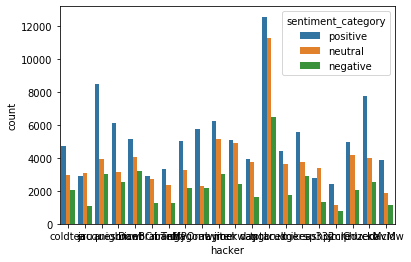

In [15]:
import seaborn 
plot1 = seaborn.countplot(x = 'hacker', hue = 'sentiment_category', data = df)

DS: 
- Decide what volume/frequency of user comments to use as a threshold
- ~~Score HN user negativity using sentiment analysis techniques on their comments~~
- Rank-order users based on negativity score and do the same with their most negative comments
- Make rankings and comments accessible to the rest of the team. 
E.g. deploy rankings via Flask API (or equivalent) to receive inputs (HN username), and output negativity score & ranking in JSON format.
